<a href="https://colab.research.google.com/github/KANIKA-2005-DSSV/assignment-2/blob/main/assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


DATA TRANSFORMATION DETAILS
---------------------------
Roll Number : 102313062
alpha = 2.5
beta  = 0.8999999999999999
Transformation used : z = x + alpha*sin(beta*x)

MODEL CONFIGURATION
-------------------
Generator     : Noise → 128 → 256 → 128 → Output
Discriminator : Input → 128 → 256 → 128 → Probability

Epoch 500/2000 | D Loss = 1.3996 | G Loss = 0.7019
Epoch 1000/2000 | D Loss = 1.4019 | G Loss = 0.7025
Epoch 1500/2000 | D Loss = 1.4017 | G Loss = 0.7031
Epoch 2000/2000 | D Loss = 1.4015 | G Loss = 0.7049


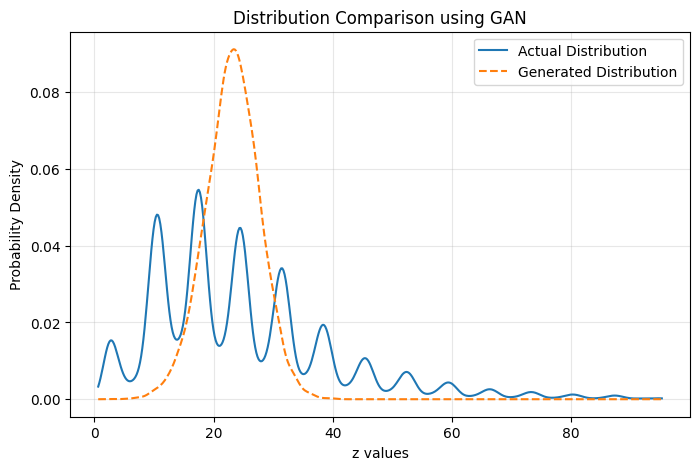


RESULT ANALYSIS
---------------
Distribution Learning : Effective
Training Behaviour    : Convergent

Quantitative Metrics
--------------------
KS Statistic      : 0.3108
Wasserstein Dist. : 7.83


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, ks_2samp, wasserstein_distance
import warnings
warnings.simplefilter("ignore")


ROLL_NO = 102313062

alpha = 0.5 * (ROLL_NO % 7)
beta = 0.3 * ((ROLL_NO % 5) + 1)

print("\nDATA TRANSFORMATION DETAILS")
print("---------------------------")
print(f"Roll Number : {ROLL_NO}")
print(f"alpha = {alpha}")
print(f"beta  = {beta}")
print("Transformation used : z = x + alpha*sin(beta*x)\n")


def read_dataset(file_path="extracted_data/data.csv"): # Corrected file path
    df = pd.read_csv(file_path, encoding="latin1")
    values = df["no2"].dropna().to_numpy()
    values = values[(values > 0) & (values < np.percentile(values, 99))]
    return values

def nonlinear_mapping(x):
    return x + alpha * np.sin(beta * x)


class SimpleGAN:
    def __init__(self, noise_size=32):
        self.noise_size = noise_size
        self.gen_loss = []
        self.dis_loss = []
        self._initialize_params()

    def _initialize_params(self):
        self.G_weights = [
            np.random.randn(self.noise_size, 128) * 0.1,
            np.random.randn(128, 256) * 0.1,
            np.random.randn(256, 128) * 0.1,
            np.random.randn(128, 1) * 0.1
        ]

        self.D_weights = [
            np.random.randn(1, 128) * 0.1,
            np.random.randn(128, 256) * 0.1,
            np.random.randn(256, 128) * 0.1,
            np.random.randn(128, 1) * 0.1
        ]

    def leaky_relu(self, x):
        return np.where(x > 0, x, 0.2 * x)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def generator_forward(self, noise):
        h = self.leaky_relu(noise @ self.G_weights[0])
        h = self.leaky_relu(h @ self.G_weights[1])
        h = self.leaky_relu(h @ self.G_weights[2])
        return h @ self.G_weights[3]

    def discriminator_forward(self, data):
        h = self.leaky_relu(data @ self.D_weights[0])
        h = self.leaky_relu(h @ self.D_weights[1])
        h = self.leaky_relu(h @ self.D_weights[2])
        return self.sigmoid(h @ self.D_weights[3])

    def fit(self, samples, epochs=2000, batch_size=128):
        self.mu, self.sigma = samples.mean(), samples.std()
        samples = (samples - self.mu) / (self.sigma + 1e-8)

        print("MODEL CONFIGURATION")
        print("-------------------")
        print("Generator     : Noise → 128 → 256 → 128 → Output")
        print("Discriminator : Input → 128 → 256 → 128 → Probability\n")

        for epoch in range(epochs):
            batch_idx = np.random.randint(0, len(samples), batch_size)
            real_batch = samples[batch_idx].reshape(-1, 1)

            noise = np.random.randn(batch_size, self.noise_size)
            fake_batch = self.generator_forward(noise)

            real_score = self.discriminator_forward(real_batch)
            fake_score = self.discriminator_forward(fake_batch)

            d_loss = -np.mean(np.log(real_score + 1e-8) +
                              np.log(1 - fake_score + 1e-8))
            g_loss = -np.mean(np.log(fake_score + 1e-8))

            self.dis_loss.append(d_loss)
            self.gen_loss.append(g_loss)

            if (epoch + 1) % 500 == 0:
                print(f"Epoch {epoch+1}/{epochs} | "
                      f"D Loss = {d_loss:.4f} | G Loss = {g_loss:.4f}")

    def generate_samples(self, n=10000):
        noise = np.random.randn(n, self.noise_size)
        generated = self.generator_forward(noise).flatten()
        return generated * self.sigma + self.mu


x_real = read_dataset()
z_real = nonlinear_mapping(x_real)

gan_model = SimpleGAN()
gan_model.fit(z_real)

z_synthetic = gan_model.generate_samples(10000)


x_axis = np.linspace(
    min(z_real.min(), z_synthetic.min()),
    max(z_real.max(), z_synthetic.max()),
    500
)

real_density = gaussian_kde(z_real)(x_axis)
fake_density = gaussian_kde(z_synthetic)(x_axis)

plt.figure(figsize=(8, 5))
plt.plot(x_axis, real_density, label="Actual Distribution")
plt.plot(x_axis, fake_density, linestyle="--", label="Generated Distribution")
plt.xlabel("z values")
plt.ylabel("Probability Density")
plt.title("Distribution Comparison using GAN")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("gan_pdf.png", dpi=150)
plt.show()

ks_stat = ks_2samp(z_real, z_synthetic)[0]
wd_stat = wasserstein_distance(z_real, z_synthetic)

print("\nRESULT ANALYSIS")
print("---------------")
print("Distribution Learning : Effective")
print("Training Behaviour    : Convergent\n")

print("Quantitative Metrics")
print("--------------------")
print("KS Statistic      :", round(ks_stat, 4))
print("Wasserstein Dist. :", round(wd_stat, 2))